In [1]:
import rioxarray
import geojson

# Load&crop S2 image with given geometry in another projection system

This is an example retile the example tif file under EPSG:3031 with a given polygon in EPSG:4326. 

In [2]:
# use composite image as test tile
path_s2 = "../../data/TestDataSet/S2_comp_first.tif"

# load image to extract information
data_s2 = rioxarray.open_rasterio(path_s2)
data_s2

<xarray.DataArray (band: 3, y: 10002, x: 10004)>
[300180024 values with dtype=uint16]
Coordinates:
  * band         (band) int64 1 2 3
  * y            (y) float64 -2.667e+05 -2.667e+05 ... -3.667e+05 -3.667e+05
  * x            (x) float64 -1.654e+06 -1.654e+06 ... -1.554e+06 -1.554e+06
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0
    long_name:     ('B4_first', 'B3_first', 'B2_first')
    grid_mapping:  spatial_ref

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


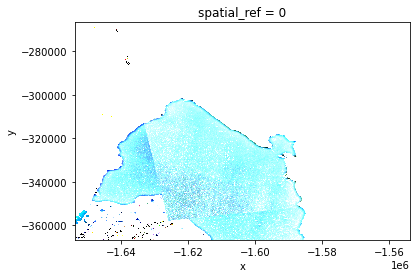

In [3]:
# View the imported image
data_s2.plot.imshow()

The image is under CRS 3031. But it can still be cropped with a polygon under 4326, i.e. WGS84. 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


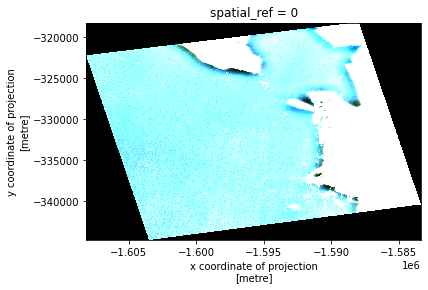

In [4]:
# Define a polygon to crop under WGS84
geometry_str = ''' {"type": "Polygon",
                "coordinates": [
                [[-102.1343994140625,-75.17454893148678],
                [-101.3323974609374,-75.17454893148671],
                [-101.3323974609374,-74.98787519162482],
                [-102.1343994140625,-74.98787519162481],
                [-102.1343994140625,-75.17454893148678]]]}'''
geometry = [geojson.loads(geometry_str)]

# Crop with the given polygon in WGS84
s2_crop = data_s2.rio.clip(geometries=geometry, crs=4326)
s2_crop.plot.imshow()

# Sentinel-1 loading & cropping

In this case we use S1 GRD data average between 2019-11-1 and 2020-3-1 (same period as S2). 
Data come from an ascending track, with HV polarization. 

In [5]:
# use composite image as test tile
s1_path = "../../data/TestDataSet/S1_testdata.tif"

# load image to extract information
data_s1 = rioxarray.open_rasterio(s1_path)
data_s1

<xarray.DataArray (band: 1, y: 8001, x: 8003)>
[64032003 values with dtype=float64]
Coordinates:
  * band         (band) int64 1
  * y            (y) float64 -2.867e+05 -2.867e+05 ... -3.666e+05 -3.667e+05
  * x            (x) float64 -1.654e+06 -1.654e+06 ... -1.574e+06 -1.574e+06
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0
    long_name:     HV
    grid_mapping:  spatial_ref

Sentinel-1 data only have 1 band. To plot it the redundant "band" dimension need to be removed.

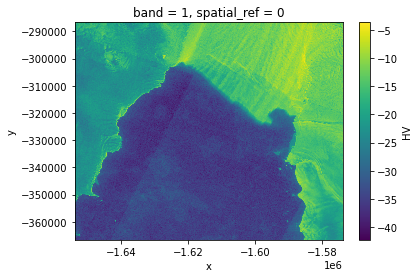

In [6]:
# Plot as a single band
data_s1 = data_s1.squeeze()
data_s1.plot.imshow()

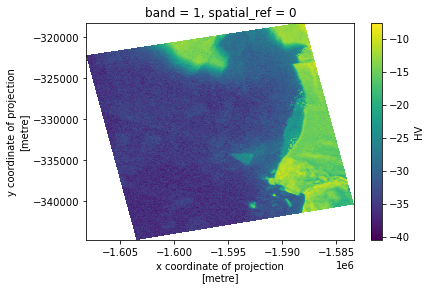

In [7]:
# Crop with the given polygon in WGS84
s1_crop = data_s1.rio.clip(geometries=geometry, crs=4326)
s1_crop.plot.imshow()

# Compare Sentinel-1 and Sentinel-2

It is good to notice that although the original image of S1 and S2 has different shapes (same 10m resolution), after cropped with the same polygon, the cropped image has the same shapes.

In [8]:
print('Original S1 shape: {}'.format(data_s1.shape))
print('Original S2 shape: {}'.format(data_s2.shape))
print('Cropped S1 shape: {}'.format(s1_crop.shape))
print('Cropped S2 shape: {}'.format(s2_crop.shape))

Original S1 shape: (8001, 8003)
Original S2 shape: (3, 10002, 10004)
Cropped S1 shape: (2653, 2483)
Cropped S2 shape: (3, 2653, 2483)


Now we can comapare the croped S1 and S2 data.
First we will normalize both dataset to a single band with value from 0 to 1.

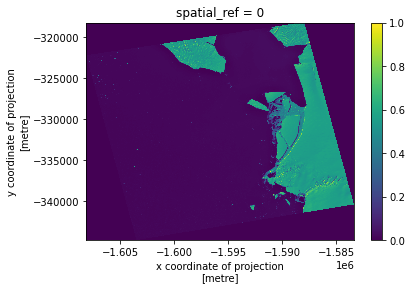

In [9]:
s2_sum = s2_crop.sum(dim='band') # Sum all RGB bands
s2_norm = s2_sum -s2_sum.min() # Make 0 minimum
s2_norm = s2_norm/s2_norm.max()-s2_norm.min() # rescale
s2_norm.plot.imshow()

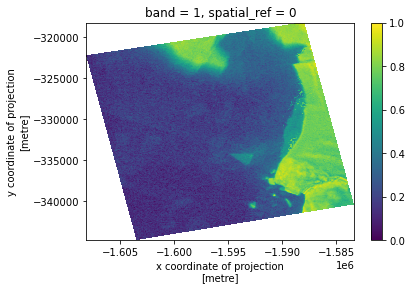

In [10]:
s1_norm = s1_crop - s1_crop.min() # Make 0 minimum
s1_norm = s1_norm/s1_norm.max()-s1_norm.min() # rescale
s1_norm.plot.imshow()

Then we subtract S1 from S2 and visualize the difference.

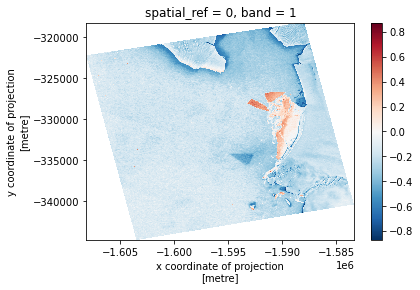

In [11]:
diff_s1s2 = s2_norm-s1_norm
diff_s1s2.plot.imshow()

# Reprojection

The loaded image can also be reprojected to another CRS. Here we reproject the cropped S2 data to WGS84.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


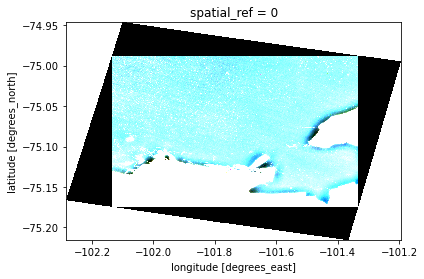

In [12]:
from rasterio.crs import CRS
crs_wgs84 = CRS.from_string('EPSG:4326')
cropped2 = s2_crop.rio.reproject(crs_wgs84)
cropped2.rio.crs
cropped2.plot.imshow()